In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler


In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9595 entries, 0 to 9594
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9595 non-null   int64 
 1   Utterance     9595 non-null   object
 2   Speaker       9595 non-null   object
 3   Sentiment     9595 non-null   object
 4   Dialogue_ID   9595 non-null   int64 
 5   Utterance_ID  9595 non-null   int64 
 6   Season        9595 non-null   int64 
 7   Episode       9595 non-null   int64 
 8   StartTime     9595 non-null   object
 9   EndTime       9595 non-null   object
 10  Emotion       9595 non-null   object
dtypes: int64(5), object(6)
memory usage: 824.7+ KB


In [ ]:
train_df.isnull().sum()

Sr No.          0
Utterance       0
Speaker         0
Sentiment       0
Dialogue_ID     0
Utterance_ID    0
Season          0
Episode         0
StartTime       0
EndTime         0
Emotion         0
dtype: int64

In [ ]:
test_df.isnull().sum()

Sr No.          0
Utterance       0
Speaker         0
Sentiment       0
Dialogue_ID     0
Utterance_ID    0
Season          0
Episode         0
StartTime       0
EndTime         0
dtype: int64

In [ ]:
train_df.head(10)

,Sr No.,Utterance,Speaker,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Emotion
0,2919,Why don’t we do a trial run.,Supervisor,neutral,308,2,7,13,"00:04:25,014","00:04:28,141",neutral
1,12609,Y’know I don’t understand why they didn’t cry....,Ross,negative,163,0,8,18,"00:21:14,261","00:21:18,014",sadness
2,12880,Could've been a peach.,Chandler,neutral,188,6,1,4,"00:07:08,428","00:07:11,138",neutral
3,359,Uh-huh. But it was a first for the rest of my ...,Ross,neutral,34,7,5,23,"00:14:48,386","00:14:49,386",neutral
4,4813,This will be your phone.,Stage Director,neutral,514,1,5,4,"00:07:24,777","00:07:26,403",neutral
5,11433,Behind my brother's back? ... is exactly the ...,Monica,negative,36,1,1,24,"00:17:58,202","00:18:05,249",anger
6,10999,What?,Rachel,neutral,102,1,1,2,"0:13:42,477","0:13:43,955",neutral
7,12417,I can't do it.,Joey,negative,140,13,5,10,"00:06:24,008","00:06:27,719",sadness
8,9469,You're you.,Chandler,neutral,990,9,1,13,"0:13:45,075","0:13:46,719",neutral
9,5326,All I had to do was pay $25 and wait in line f...,Monica,negative,564,9,4,15,"00:13:44,406","00:13:47,200",sadness


In [ ]:
train_df.shape

(9595, 11)

In [ ]:
a = train_df["Sentiment"].unique()
print(a)
a = train_df["Emotion"].unique()
print(a)

['neutral' 'negative' 'positive']
['neutral' 'sadness' 'anger' 'joy' 'disgust' 'fear' 'surprise']


In [ ]:
train_df["StartTime"]= pd.to_datetime(train_df["StartTime"])
train_df["EndTime"]= pd.to_datetime(train_df["EndTime"])

test_df["StartTime"]= pd.to_datetime(test_df["StartTime"])
test_df["EndTime"]= pd.to_datetime(test_df["EndTime"])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9595 entries, 0 to 9594
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Sr No.        9595 non-null   int64         
 1   Utterance     9595 non-null   object        
 2   Speaker       9595 non-null   object        
 3   Sentiment     9595 non-null   object        
 4   Dialogue_ID   9595 non-null   int64         
 5   Utterance_ID  9595 non-null   int64         
 6   Season        9595 non-null   int64         
 7   Episode       9595 non-null   int64         
 8   StartTime     9595 non-null   datetime64[ns]
 9   EndTime       9595 non-null   datetime64[ns]
 10  Emotion       9595 non-null   object        
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 824.7+ KB


In [ ]:
train_df["Duration"] = train_df["EndTime"]-train_df["StartTime"]
train_df["Duration"] = train_df["EndTime"]-train_df["StartTime"]

test_df["Duration"] = test_df["EndTime"]-test_df["StartTime"]
test_df["Duration"] = test_df["EndTime"]-test_df["StartTime"]

In [ ]:
def seconds(x):
    return x.total_seconds()
train_df["Duration"] = train_df["Duration"].apply(seconds)
test_df["Duration"] = test_df["Duration"].apply(seconds)

In [ ]:
speak = list(train_df.Speaker)
extra = []
for i in test_df["Speaker"]:
    if i not in speak:
        extra.append(i)

In [ ]:
ToChange = ["Speaker","Sentiment"]
D = {}
for i in ToChange:
    dummy = 0
    d = {}
    for j in train_df[i].unique():

        d[j] = dummy
        dummy+=1

    if i=="Speaker":
        for j in extra:
            d[j] = dummy
            dummy+=1
    D[i]=d

In [ ]:
a = { "anger":0,
"disgust":1,
"fear":2,
"joy":3,
"neutral":4,
"sadness":5,
"surprise":6}
train_df.replace({"Emotion":a,"Speaker":D["Speaker"],"Sentiment":D["Sentiment"]},inplace=True)
test_df.replace({"Speaker":D["Speaker"],"Sentiment":D["Sentiment"]},inplace=True)

In [ ]:
train_df

,Sr No.,Utterance,Speaker,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Emotion,Duration
0,2919,Why don’t we do a trial run.,0,0,308,2,7,13,2023-09-05 00:04:25.014,2023-09-05 00:04:28.141,4,3.127
1,12609,Y’know I don’t understand why they didn’t cry....,1,1,163,0,8,18,2023-09-05 00:21:14.261,2023-09-05 00:21:18.014,5,3.753
2,12880,Could've been a peach.,2,0,188,6,1,4,2023-09-05 00:07:08.428,2023-09-05 00:07:11.138,4,2.710
3,359,Uh-huh. But it was a first for the rest of my ...,1,0,34,7,5,23,2023-09-05 00:14:48.386,2023-09-05 00:14:49.386,4,1.000
4,4813,This will be your phone.,3,0,514,1,5,4,2023-09-05 00:07:24.777,2023-09-05 00:07:26.403,4,1.626
...,...,...,...,...,...,...,...,...,...,...,...,...
9590,13635,"Oh, I uh, just came by to pick up my skull. We...",1,0,270,2,1,9,2023-09-05 00:04:55.253,2023-09-05 00:05:02.884,4,7.631
9591,7993,And any extra cash my father has he saves for ...,2,0,843,3,7,2,2023-09-05 00:12:39.508,2023-09-05 00:12:44.220,4,4.712
9592,8636,"No! No-no. Look, there’s a bug stuck in tar ri...",6,2,908,6,7,12,2023-09-05 00:02:36.156,2023-09-05 00:02:39.867,6,3.711
9593,3570,Wow! Nice! Manly and also kind of a slut.,7,1,376,3,7,22,2023-09-05 00:15:59.208,2023-09-05 00:16:03.836,2,4.628


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9595 entries, 0 to 9594
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Sr No.        9595 non-null   int64         
 1   Utterance     9595 non-null   object        
 2   Speaker       9595 non-null   int64         
 3   Sentiment     9595 non-null   int64         
 4   Dialogue_ID   9595 non-null   int64         
 5   Utterance_ID  9595 non-null   int64         
 6   Season        9595 non-null   int64         
 7   Episode       9595 non-null   int64         
 8   StartTime     9595 non-null   datetime64[ns]
 9   EndTime       9595 non-null   datetime64[ns]
 10  Emotion       9595 non-null   int64         
 11  Duration      9595 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(8), object(1)
memory usage: 899.7+ KB


In [ ]:
npl = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

In [ ]:
new_Utterance_train = []
for i in train_df["Utterance"]:
    # s = ''
    # for j in i.split(" "):

    #     s = s + " " + j
    # s = s.strip()
    doc = npl(i)

    unique = set()
    for token in doc:
        unique.add(token.text)
    a = ''
    for token in unique:
        a+=' '+str(token)
    a = a.strip()
#     print(a)
    c = ''
    for i in a.split():
        stemmed_word = stemmer.stem(i)
        c += ' '+stemmed_word
    c = c.strip()

    new_Utterance_train.append(c)
#     print(new_Utterance[-1])

new_Utterance_test = []
for i in test_df["Utterance"]:
    # s = ''
    # for j in i.split(" "):

    #     s = s + " " + j
    # s = s.strip()
    doc = npl(i)
#     print(s)
    unique = set()
    for token in doc:
        unique.add(token.text)
    a = ''
    for token in unique:
        a+=' '+str(token)
    a = a.strip()
#     print(a)
    c = ''
    for i in a.split():
        stemmed_word = stemmer.stem(i)
        c += ' '+stemmed_word
    c = c.strip()

    new_Utterance_test.append(c)
#     print(new_Utterance[-1])

In [ ]:
df = pd.DataFrame(new_Utterance_train)
train_df = pd.concat([train_df, df], axis=1)

df = pd.DataFrame(new_Utterance_test)
test_df = pd.concat([test_df, df], axis=1)


In [ ]:
test_df

,Sr No.,Utterance,Speaker,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Duration,0
0,8267,"And before you know it, she's with him.",6,1,869,11,3,12,2023-09-04 00:13:09.455,2023-09-04 00:13:11.456,2.001,"know , him it and she . 's befor with you"
1,6211,"Oh, oh, but y'know, you always see these reall...",7,0,652,13,1,6,2023-09-04 00:02:40.335,2023-09-04 00:02:46.582,6.247,"of alway oh could but , guy y'know see women t..."
2,10948,"Oh yeah? Hi, Ken Adams, nice to meet you.",6,0,95,3,8,4,2023-09-04 00:12:50.394,2023-09-04 00:12:54.147,3.753,", meet ? . oh ken adam nice yeah hi you to"
3,8438,"But-but, Liam’s on my team.",1,2,888,16,4,15,2023-09-04 00:17:03.355,2023-09-04 00:17:05.064,1.709,", team liam . - ’s on but but my"
4,3190,Oh God!,4,1,336,11,3,10,2023-09-04 00:12:48.184,2023-09-04 00:12:49.225,1.041,god ! oh
...,...,...,...,...,...,...,...,...,...,...,...,...
4108,3920,"Yeah, Ross is great.",4,0,423,1,1,23,2023-09-04 00:11:29.606,2023-09-04 00:11:32.260,2.654,", ross . is yeah great"
4109,7896,I don’t know. Me neither.,7,0,834,15,6,12,2023-09-04 00:04:43.283,2023-09-04 00:04:47.286,4.003,know neither me do n’t . i
4110,11828,"I mean I’ll have to check with him first, but ...",6,0,80,9,4,4,2023-09-04 00:07:19.522,2023-09-04 00:07:22.065,2.543,", ’ll him think it . i check he have be mean w..."
4111,3253,"All right. Chandler, you can either spin the w...",6,0,342,9,8,20,2023-09-04 00:07:52.919,2023-09-04 00:07:56.672,3.753,", spin googl a card . can wheel chandler eithe..."


In [ ]:
train_df

,Sr No.,Utterance,Speaker,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Emotion,Duration,0
0,2919,Why don’t we do a trial run.,0,0,308,2,7,13,2023-09-04 00:04:25.014,2023-09-04 00:04:28.141,4,3.127,a do n’t we run . whi trial
1,12609,Y’know I don’t understand why they didn’t cry....,1,1,163,0,8,18,2023-09-04 00:21:14.261,2023-09-04 00:21:18.014,5,3.753,speech whi do n’t . a cri they i did it wa und...
2,12880,Could've been a peach.,2,0,188,6,1,4,2023-09-04 00:07:08.428,2023-09-04 00:07:11.138,4,2.710,a . peach 've been could
3,359,Uh-huh. But it was a first for the rest of my ...,1,0,34,7,5,23,2023-09-04 00:14:48.386,2023-09-04 00:14:49.386,4,1.000,it a . uh - rest of but wa huh for my first th...
4,4813,This will be your phone.,3,0,514,1,5,4,2023-09-04 00:07:24.777,2023-09-04 00:07:26.403,4,1.626,. phone will be your thi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9590,13635,"Oh, I uh, just came by to pick up my skull. We...",1,0,270,2,1,9,2023-09-04 00:04:55.253,2023-09-04 00:05:02.884,4,7.631,", ... came up skull . not pick i oh by just we..."
9591,7993,And any extra cash my father has he saves for ...,2,0,843,3,7,2,2023-09-04 00:12:39.508,2023-09-04 00:12:44.220,4,4.712,ha for trip and extra yearli save hi he ani fa...
9592,8636,"No! No-no. Look, there’s a bug stuck in tar ri...",6,2,908,6,7,12,2023-09-04 00:02:36.156,2023-09-04 00:02:39.867,6,3.711,", here no a tar . - ’s in stuck bug there look..."
9593,3570,Wow! Nice! Manly and also kind of a slut.,7,1,376,3,7,22,2023-09-04 00:15:59.208,2023-09-04 00:16:03.836,2,4.628,a of . and slut manli nice wow also kind !


<Axes: xlabel='Dialogue_ID', ylabel='Density'>

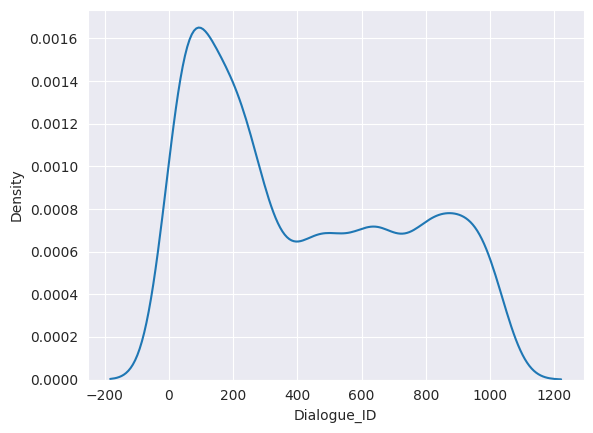

In [ ]:
plt.plot(figsize=(15,15))
sns.kdeplot(x="Dialogue_ID",data=test_df)

In [ ]:
new_train = pd.concat([train_df["Speaker"],train_df["Sentiment"],train_df["Utterance_ID"],train_df["Dialogue_ID"],train_df["Duration"],train_df["Emotion"]],axis=1)
new_test = pd.concat([test_df["Speaker"],test_df["Sentiment"],test_df["Utterance_ID"],test_df["Duration"]],axis=1)

<Axes: >

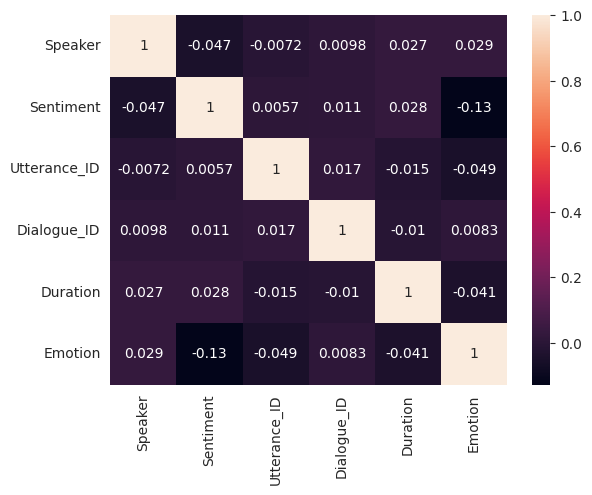

In [ ]:
sns.heatmap(data=new_train.corr(),annot=True)

In [ ]:
new_train = pd.concat([train_df["Sentiment"]],axis=1)
new_test = pd.concat([test_df["Sentiment"]],axis=1)

In [ ]:
new = pd.concat([train_df["Speaker"],train_df["Sentiment"],train_df["Duration"]],axis=1)

In [ ]:
new_test

,Speaker,Sentiment,Utterance_ID,Duration
0,6,1,11,2.0
1,7,0,13,6.0
2,6,0,3,4.0
3,1,2,16,2.0
4,4,1,11,1.0
...,...,...,...,...
4108,4,0,1,3.0
4109,7,0,15,4.0
4110,6,0,9,3.0
4111,6,0,9,4.0


In [ ]:
min_max = preprocessing.MinMaxScaler()
scaled_df = min_max.fit_transform(new.values)
New = pd.DataFrame(scaled_df,columns=new.columns)

In [ ]:
scaler = StandardScaler()

scaled_train = scaler.fit_transform(new_train.values)
scaled_test = scaler.transform(new_test.values)

New_train = pd.DataFrame(scaled_train,columns=new_train.columns)
New_test = pd.DataFrame(scaled_test,columns=new_test.columns)

In [ ]:
X_train,x_test,Y_train,y_test = train_test_split(pd.concat([train_df[0],New],axis=1),train_df["Emotion"],test_size=0.2,stratify=train_df["Emotion"],random_state=42,shuffle=True)

In [ ]:
tfidf = TfidfVectorizer(max_df = 0.3,min_df=5,token_pattern=r'(?u)\b\w+\b|\b\W+\b',stop_words = "english",norm="l2")

X = tfidf.fit_transform(X_train[0])
X = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
X = pd.concat([X,X_train["Speaker"],X_train["Sentiment"],X_train["Duration"],X_train["Utterance_ID"],Y_train],axis=1)

x = tfidf.transform(x_test[0])
x = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names_out())
x = pd.concat([x,x_test["Speaker"],x_test["Sentiment"],x_test["Duration"],x_test["Utterance_ID"],y_test],axis=1)

In [ ]:
X.dropna(inplace=True)
x.dropna(inplace=True)

In [ ]:
Y_train = X["Emotion"]
y_test = x["Emotion"]

X.drop("Emotion",axis=1,inplace=True)
x.drop("Emotion",axis=1,inplace=True)

In [ ]:
print(X.shape)
print(x.shape)

print(Y_train.shape)
print(Y_train.value_counts())
print(y_test.shape)
print(y_test.value_counts())

In [ ]:
print(X_train.shape)
print(x_test.shape)

print(Y_train.shape)
print(Y_train.value_counts())
print(y_test.shape)
print(y_test.value_counts())

In [ ]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X, Y_train)

nb_predictions = nb_classifier.predict(X)
nb_accuracy = accuracy_score(Y_train, nb_predictions)
print("Multinomial Naive Bayes Accuracy train:", nb_accuracy)

nb_predictions = nb_classifier.predict(x)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Multinomial Naive Bayes Accuracy:", nb_accuracy)
print(classification_report(y_test, nb_predictions))

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=100)

knn_classifier.fit(X, Y_train)
knn_predictions = knn_classifier.predict(x)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)
print(classification_report(y_test, knn_predictions))

In [ ]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X, Y_train)

svm_predictions = svm_classifier.predict(X)
svm_accuracy = accuracy_score(Y_train, svm_predictions)
print("SVM Accuracy train:", svm_accuracy)

svm_predictions = svm_classifier.predict(x)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_predictions))

Best Hyperparameters: {'C': 0.1}
Best Accuracy: 0.7498785818358428


In [ ]:
gb_classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, random_state=42)

gb_classifier.fit(X, Y_train)

gb_predictions = gb_classifier.predict(X)

accuracy = accuracy_score(Y_train, gb_predictions)
print("Accuracy train:", accuracy)

gb_predictions = gb_classifier.predict(x)

accuracy = accuracy_score(y_test, gb_predictions)
print("Accuracy:", accuracy)

print(classification_report(y_test, gb_predictions))

In [ ]:
mini = []
num = []
for i in range(1,11):
#     print("*"*50)
    num.append(i)
    tfidf = TfidfVectorizer(max_df = 0.3,min_df=i,stop_words = "english",norm="l2")
    train_tfidf = tfidf.fit_transform(train_df[0])
    mini.append(len(tfidf.vocabulary_))

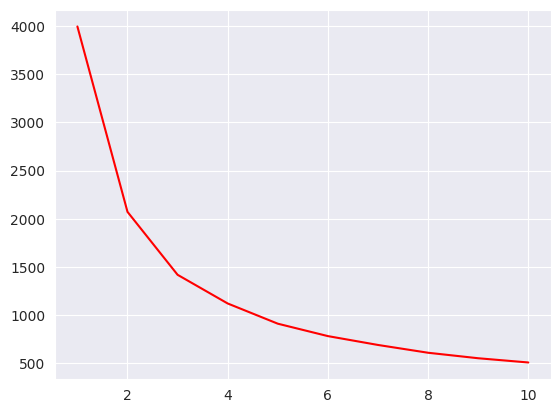

In [ ]:
plt.plot(num, mini, color ="red")

In [ ]:
maxi = []
num = []
for i in range(1,11):
#     print("*"*50)
    num.append(i/10)
    tfidf = TfidfVectorizer(max_df = i/10,min_df=5,stop_words = "english",norm="l2")
    train_tfidf = tfidf.fit_transform(train_df[0])
    maxi.append(len(tfidf.vocabulary_))

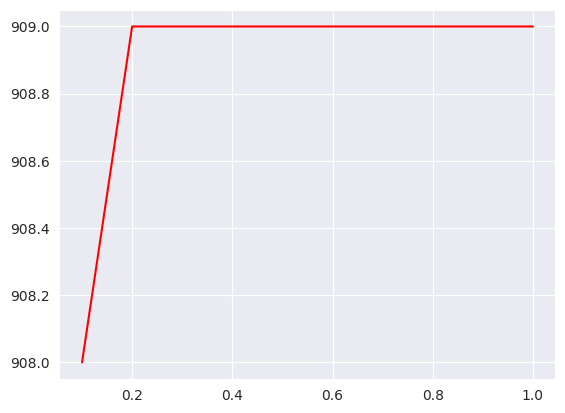

In [ ]:
plt.plot(num, maxi, color ="red")

In [ ]:
type(train_df[0])

pandas.core.series.Series

In [ ]:
# tfidf = TfidfVectorizer(max_df = 0.3,min_df=4,token_pattern=r'(?u)\b\w+\b|\b\W+\b',stop_words = "english",norm="l2")
tfidf = TfidfVectorizer(max_df = 0.2,min_df=5,stop_words = "english",norm="l2")

X = tfidf.fit_transform(train_df[0])
X = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
# X = pd.concat([X,New_train,train_df["Emotion"]],axis=1)
X = pd.concat([X,train_df["Emotion"],New_train],axis=1)

x = tfidf.transform(test_df[0])
x = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names_out())
x = pd.concat([x,New_test],axis=1)

In [ ]:
X.dropna(inplace=True)
x.dropna(inplace=True)

Y = X["Emotion"]

X.drop("Emotion",axis=1,inplace=True)

In [ ]:
print(X.shape)
print(x.shape)
print(Y.shape)

(9595, 910)
(4113, 910)
(9595,)


In [ ]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X, Y)

# svm_predictions = svm_classifier.predict(x)
trial = svm_classifier.predict(X)
svm_accuracy = accuracy_score(Y, trial)
# print("SVM Accuracy:", svm_accuracy)
print(classification_report(Y, trial))

              precision    recall  f1-score   support

           0       0.53      0.88      0.66      1164
           1       0.85      0.11      0.20       255
           2       0.86      0.09      0.17       258
           3       0.82      0.98      0.90      1626
           4       1.00      1.00      1.00      4441
           5       0.79      0.47      0.59       715
           6       0.66      0.47      0.55      1136

    accuracy                           0.83      9595
   macro avg       0.79      0.57      0.58      9595
weighted avg       0.85      0.83      0.81      9595



In [ ]:
svm_predictions = svm_classifier.predict(x)

In [ ]:
gb_classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, random_state=42)

gb_classifier.fit(X, Y)

gb_predictions = gb_classifier.predict(X)

accuracy = accuracy_score(Y, gb_predictions)
print("Accuracy train:", accuracy)

# gb_predictions = gb_classifier.predict(x)

# accuracy = accuracy_score(y_test, gb_predictions)
# print("Accuracy:", accuracy)

print(classification_report(Y, gb_predictions))

Accuracy train: 0.7850964043772798
              precision    recall  f1-score   support

           0       0.43      0.97      0.59      1164
           1       0.96      0.09      0.17       255
           2       0.94      0.06      0.12       258
           3       0.79      0.99      0.87      1626
           4       1.00      1.00      1.00      4441
           5       0.80      0.15      0.25       715
           6       0.72      0.19      0.30      1136

    accuracy                           0.79      9595
   macro avg       0.81      0.49      0.47      9595
weighted avg       0.84      0.79      0.74      9595



Remove Speaker:
0.82 svm
0.79 gradient

In [ ]:
final = pd.DataFrame(svm_predictions)
final = pd.concat([test_df['Sr No.'],final],axis=1)
final.rename(columns = {0:'Emo_num'}, inplace = True)

In [ ]:
final

,Sr No.,Emo_num
0,8267,0
1,6211,4
2,10948,4
3,8438,3
4,3190,6
...,...,...
4108,3920,4
4109,7896,4
4110,11828,4
4111,3253,4


In [ ]:
submit = pd.read_csv('/content/sample_submission.csv')

In [ ]:
submit

,Sr No.,Emo_num
0,8267,4
1,6211,5
2,10948,5
3,8438,6
4,3190,3
...,...,...
4108,3920,2
4109,7896,5
4110,11828,4
4111,3253,4


In [ ]:
final.to_csv('Tanay_svm_update_nopunc.csv',index=False)

In [ ]:
final_df = pd.read_csv('/content/Tanay_svm_update_nopunc.csv')

In [ ]:
final_df

,Sr No.,Emo_num
0,8267,0
1,6211,4
2,10948,4
3,8438,3
4,3190,6
...,...,...
4108,3920,4
4109,7896,4
4110,11828,4
4111,3253,4
